# EEG Sleep Stage Classification

This notebook implements a machine learning solution for classifying EEG sleep stages into 5 classes:
- Wake
- Non-rapid eye movement (NREM) sleep stages E1, E2, E3
- Rapid Eye Movement (REM) sleep

The goal is to achieve >90% classification accuracy on the test set.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from scipy import signal
from scipy.stats import entropy, kurtosis, skew
import pywt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-05-10 17:54:37.920985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746896077.937709  720864 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746896077.944237  720864 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746896077.957106  720864 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746896077.957135  720864 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746896077.957138  720864 computation_placer.cc:177] computation placer alr

## 2. Load and Explore Data

In this dataset, each row represents a time series, with the first value of the row giving the assigned class.

In [2]:
def load_data(train_path='train.csv', test_path='test.csv'):
    # Load training data
    train_data = pd.read_csv(train_path, header=None)
    # Extract labels (first column) and features (remaining columns)
    y_train = train_data.iloc[:, 0].values
    X_train = train_data.iloc[:, 1:].values
    
    # Load test data (no labels)
    test_data = pd.read_csv(test_path, header=None)
    X_test = test_data.values
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Number of classes: {len(np.unique(y_train))}")
    
    return X_train, y_train, X_test

# Load data
X_train, y_train, X_test = load_data()

Training data shape: (4999, 178)
Test data shape: (1000, 178)
Number of classes: 5


### Visualize class distribution

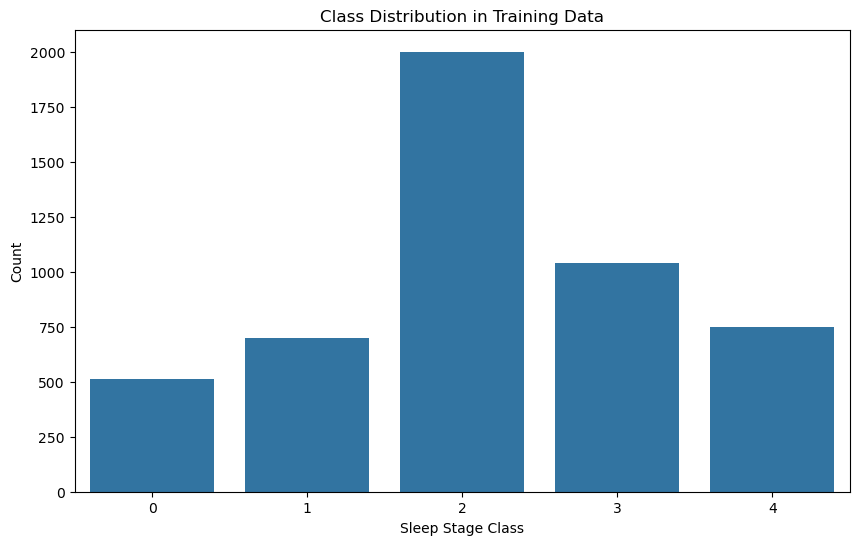


First few rows of training data:


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,-1.608303,-13.170696,-8.997802,1.347497,5.259585,-1.521367,2.651526,4.651038,3.781685,-1.521367
1,0.0,-2.825397,2.390720,3.955555,-4.216361,2.477656,2.129914,3.955555,-5.172649,5.694261,1.608303
2,0.0,-15.952625,-3.347008,-15.517949,-9.432479,-16.474237,-6.650549,-14.909402,-12.214408,-10.823443,-7.259097
3,0.0,-26.558731,-18.560684,-12.040537,-4.216361,-9.432479,1.260562,-2.216850,-3.520879,-5.781197,-6.128938
4,0.0,-5.607326,6.042003,-4.129426,-5.172649,-7.172161,-11.953602,-7.780708,-0.130403,-2.912332,-4.390232


In [3]:
# Check class distribution
class_counts = pd.Series(y_train).value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Training Data')
plt.xlabel('Sleep Stage Class')
plt.ylabel('Count')
plt.show()

# Display the first few samples
print("\nFirst few rows of training data:")
pd.DataFrame(np.column_stack([y_train[:5], X_train[:5, :10]])).head()

### Visualize example signals from each class

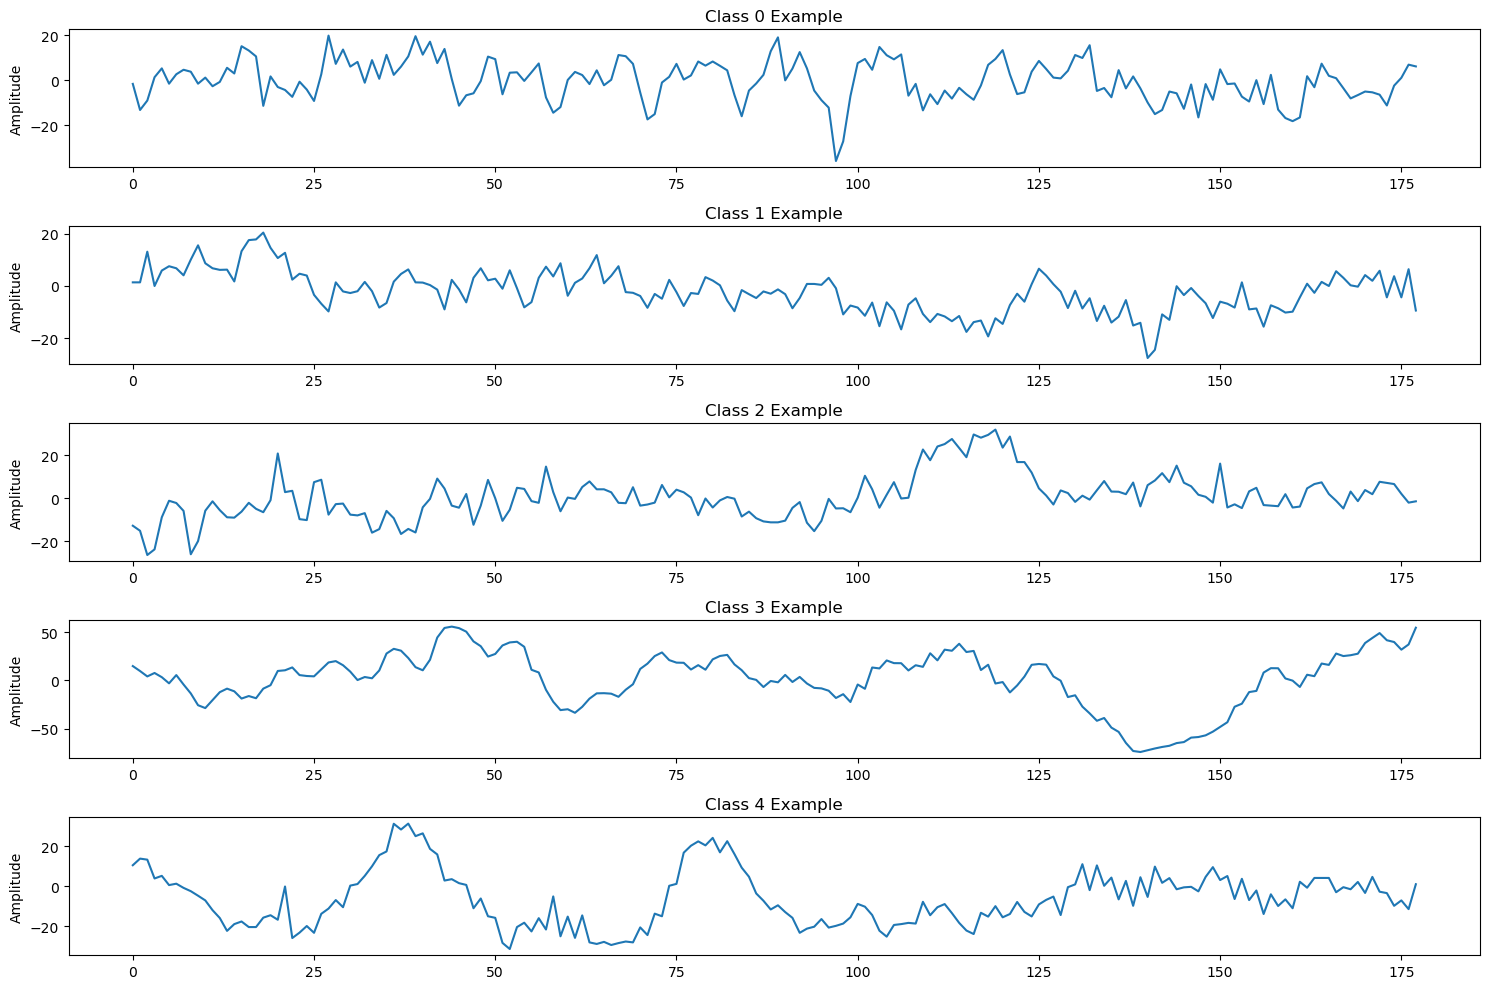

In [4]:
# Plot example signals from each class
classes = np.unique(y_train)
plt.figure(figsize=(15, 10))

for i, c in enumerate(classes):
    class_idx = np.where(y_train == c)[0][0]  # Get first example of this class
    plt.subplot(len(classes), 1, i+1)
    plt.plot(X_train[class_idx])
    plt.title(f'Class {c} Example')
    plt.ylabel('Amplitude')
    
plt.tight_layout()
plt.show()

## 3. Feature Extraction for EEG Data

For EEG sleep stage classification, we need to extract features that capture the characteristics of different sleep stages. We'll extract:
- Time domain features
- Frequency domain features (EEG bands: delta, theta, alpha, beta, gamma)
- Spectral features
- Entropy measures
- Wavelet features

In [5]:
def extract_eeg_features(X):
    print("Extracting EEG features...")
    features = []
    
    for sample in X:
        # Time domain features
        basic_stats = [
            np.mean(sample), np.std(sample), np.min(sample), np.max(sample),
            np.median(sample), np.percentile(sample, 25), np.percentile(sample, 75),
            kurtosis(sample), skew(sample)
        ]
        
        # Frequency domain features - EEG bands
        fs = 100  # Assuming 100 Hz sampling rate for EEG
        f, psd = signal.welch(sample, fs, nperseg=min(len(sample), 256))
        
        # Define EEG frequency bands
        delta_idx = np.logical_and(f >= 0.5, f <= 4)
        theta_idx = np.logical_and(f >= 4, f <= 8)
        alpha_idx = np.logical_and(f >= 8, f <= 13)
        beta_idx = np.logical_and(f >= 13, f <= 30)
        gamma_idx = np.logical_and(f >= 30, f <= 50)
        
        # Power in each frequency band
        delta_power = np.sum(psd[delta_idx]) if np.any(delta_idx) else 0
        theta_power = np.sum(psd[theta_idx]) if np.any(theta_idx) else 0
        alpha_power = np.sum(psd[alpha_idx]) if np.any(alpha_idx) else 0
        beta_power = np.sum(psd[beta_idx]) if np.any(beta_idx) else 0
        gamma_power = np.sum(psd[gamma_idx]) if np.any(gamma_idx) else 0
        
        # Band ratios (important for sleep staging)
        theta_beta_ratio = theta_power / beta_power if beta_power > 0 else 0
        alpha_beta_ratio = alpha_power / beta_power if beta_power > 0 else 0
        delta_theta_ratio = delta_power / theta_power if theta_power > 0 else 0
        
        # Total power and relative band powers
        total_power = delta_power + theta_power + alpha_power + beta_power + gamma_power
        if total_power > 0:
            rel_delta = delta_power / total_power
            rel_theta = theta_power / total_power
            rel_alpha = alpha_power / total_power
            rel_beta = beta_power / total_power
            rel_gamma = gamma_power / total_power
        else:
            rel_delta, rel_theta, rel_alpha, rel_beta, rel_gamma = 0, 0, 0, 0, 0
        
        # Spectral edge frequencies
        cumulative_power = np.cumsum(psd)
        total_cum_power = cumulative_power[-1]
        if total_cum_power > 0:
            sef_95 = f[np.where(cumulative_power >= 0.95 * total_cum_power)[0][0]]
            sef_50 = f[np.where(cumulative_power >= 0.50 * total_cum_power)[0][0]]
        else:
            sef_95, sef_50 = 0, 0
        
        # Entropy measures (important for sleep staging)
        sample_entropy = entropy(np.histogram(sample, bins=20)[0])
        
        # Hjorth parameters (commonly used in EEG analysis)
        diff_1 = np.diff(sample)
        diff_2 = np.diff(diff_1)
        
        activity = np.var(sample)
        mobility = np.sqrt(np.var(diff_1) / activity) if activity > 0 else 0
        complexity = np.sqrt(np.var(diff_2) / np.var(diff_1)) if np.var(diff_1) > 0 else 0
        
        # Wavelet features (good for time-frequency analysis)
        coeffs = pywt.wavedec(sample, 'db4', level=4)
        wavelet_features = []
        for coeff in coeffs:
            wavelet_features.extend([np.mean(coeff), np.std(coeff), np.max(coeff), np.min(coeff)])
        
        # Zero-crossing rate
        zero_crossings = np.sum(np.diff(np.signbit(sample).astype(int)) != 0)
        
        # Combine all features
        all_features = basic_stats + [
            delta_power, theta_power, alpha_power, beta_power, gamma_power,
            theta_beta_ratio, alpha_beta_ratio, delta_theta_ratio,
            rel_delta, rel_theta, rel_alpha, rel_beta, rel_gamma,
            sef_95, sef_50, sample_entropy,
            activity, mobility, complexity, zero_crossings
        ] + wavelet_features
        
        features.append(all_features)
    
    features_array = np.array(features)
    print(f"Feature extraction complete: {features_array.shape}")
    return features_array

# Extract features
X_train_features = extract_eeg_features(X_train)
X_test_features = extract_eeg_features(X_test)

Extracting EEG features...
Feature extraction complete: (4999, 49)
Extracting EEG features...
Feature extraction complete: (1000, 49)


### Additional advanced features for better performance

In [6]:
def extract_additional_features(X):
    """Extract additional EEG features proven effective for sleep staging"""
    
    print("Extracting additional advanced features...")
    features = []
    for sample in X:
        # Permutation entropy
        def perm_entropy(time_series, order=3, delay=1):
            """Calculate permutation entropy"""
            n = len(time_series)
            permutations = np.array(list(itertools.permutations(range(order))))
            c = [0] * len(permutations)
            
            for i in range(n - delay * (order - 1)):
                # Extract a window of the time series
                sorted_idx = np.argsort(time_series[i:i + delay * order:delay])
                
                # Find which permutation pattern it matches
                for j, p in enumerate(permutations):
                    if all(sorted_idx == p):
                        c[j] += 1
                        break
            
            # Calculate entropy
            c = np.array(c) / (n - delay * (order - 1))
            return -np.sum(c[c > 0] * np.log2(c[c > 0]))
        
        # Calculate permutation entropy
        perm_ent = perm_entropy(sample)
        
        # Fractal dimension (Katz)
        def katz_fd(signal):
            n = len(signal)
            if n == 0:
                return 0
                
            L = np.sum(np.sqrt(1 + np.diff(signal) ** 2))
            d = np.max(np.sqrt((np.arange(1, n) - 1) ** 2 + (signal[1:] - signal[0]) ** 2))
            
            if d > 0:
                return np.log10(n) / (np.log10(d/L) + np.log10(n))
            else:
                return 0
        
        katz_fractal_dim = katz_fd(sample)
        
        # Energy by wavelet sub-bands (better frequency resolution)
        coeffs = pywt.wavedec(sample, 'db4', level=5)
        subband_energy = [np.sum(np.square(c)) for c in coeffs]
        
        features.append([perm_ent, katz_fractal_dim] + subband_energy)
    
    return np.array(features)

# Extract additional features
X_train_additional = extract_additional_features(X_train)
X_test_additional = extract_additional_features(X_test)

# Combine with original features
X_train_features = np.hstack((X_train_features, X_train_additional))
X_test_features = np.hstack((X_test_features, X_test_additional))

print(f"Combined feature matrix shape: {X_train_features.shape}")

Extracting additional advanced features...


/home/lyes/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Extracting additional advanced features...
Combined feature matrix shape: (4999, 57)


## 4. Data Preparation for Modeling

In [7]:
# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded
)

# Split features for validation
X_train_feat_split, X_val_feat, y_train_split, y_val = train_test_split(
    X_train_features, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded
)

# Normalize features
scaler = StandardScaler()
X_train_feat_scaled = scaler.fit_transform(X_train_feat_split)
X_val_feat_scaled = scaler.transform(X_val_feat)
X_test_feat_scaled = scaler.transform(X_test_features)

# Normalize raw data for deep learning
scaler_raw = StandardScaler()
X_train_scaled = scaler_raw.fit_transform(X_train_split)
X_val_scaled = scaler_raw.transform(X_val)
X_test_scaled = scaler_raw.transform(X_test)

print("Data preparation completed")

Data preparation completed


## 5. Train Traditional Machine Learning Models

We'll train Random Forest, Gradient Boosting, and XGBoost models on our extracted features.

In [8]:
def train_traditional_models(X_train, y_train):
    print("Training traditional ML models...")
    
    # Define models - explicitly configure XGBoost for CPU
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=30, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=300, max_depth=8, random_state=42),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=300, 
            max_depth=8, 
            learning_rate=0.1, 
            random_state=42,
            tree_method='hist',  # CPU-optimized algorithm
            device='cpu',        # Explicitly use CPU
            enable_categorical=False  # Avoid GPU-related issues
        )
    }
    
    # 5-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}
    
    # Try each model, with fallback options if XGBoost fails
    for name, model in models.items():
        try:
            print(f"Training {name}...")
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
            results[name] = {
                'mean_accuracy': np.mean(cv_scores),
                'std_accuracy': np.std(cv_scores),
                'model': model
            }
            print(f"{name} - CV Accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
        except Exception as e:
            print(f"Error training {name}: {e}")
            # Skip problematic model
            continue
    
    # If we have results, find best model and train on full data
    if results:
        best_model_name = max(results, key=lambda x: results[x]['mean_accuracy'])
        best_model = results[best_model_name]['model']
        best_model.fit(X_train, y_train)
        print(f"Best traditional model: {best_model_name} with accuracy: {results[best_model_name]['mean_accuracy']:.4f}")
        return best_model, results
    else:
        # If all models failed, return RandomForest as fallback
        print("All model training failed, using basic RandomForest")
        fallback_model = RandomForestClassifier(n_estimators=100, random_state=42)
        fallback_model.fit(X_train, y_train)
        return fallback_model, {"RandomForest (fallback)": {"model": fallback_model}}

# Train traditional ML models
best_ml_model, ml_results = train_traditional_models(X_train_feat_scaled, y_train_split)

Training traditional ML models...
Training Random Forest...
Random Forest - CV Accuracy: 0.6757 (±0.0120)
Training Gradient Boosting...
Gradient Boosting - CV Accuracy: 0.6822 (±0.0065)
Training XGBoost...
XGBoost - CV Accuracy: 0.6864 (±0.0089)
Best traditional model: XGBoost with accuracy: 0.6864


### Evaluate ML models on validation set

Best ML Model Validation Accuracy: 0.7050

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       102
           1       0.64      0.55      0.59       140
           2       0.68      0.75      0.71       400
           3       0.79      0.81      0.80       208
           4       0.69      0.62      0.65       150

    accuracy                           0.70      1000
   macro avg       0.71      0.68      0.69      1000
weighted avg       0.70      0.70      0.70      1000



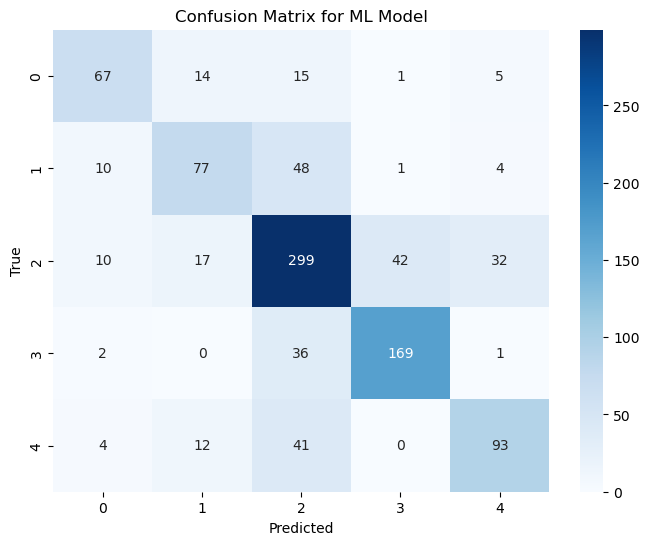

In [9]:
# Predict on validation set
ml_val_preds = best_ml_model.predict(X_val_feat_scaled)
ml_val_accuracy = accuracy_score(y_val, ml_val_preds)

print(f"Best ML Model Validation Accuracy: {ml_val_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, ml_val_preds))

# Plot confusion matrix
cm = confusion_matrix(y_val, ml_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for ML Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Feature importance analysis

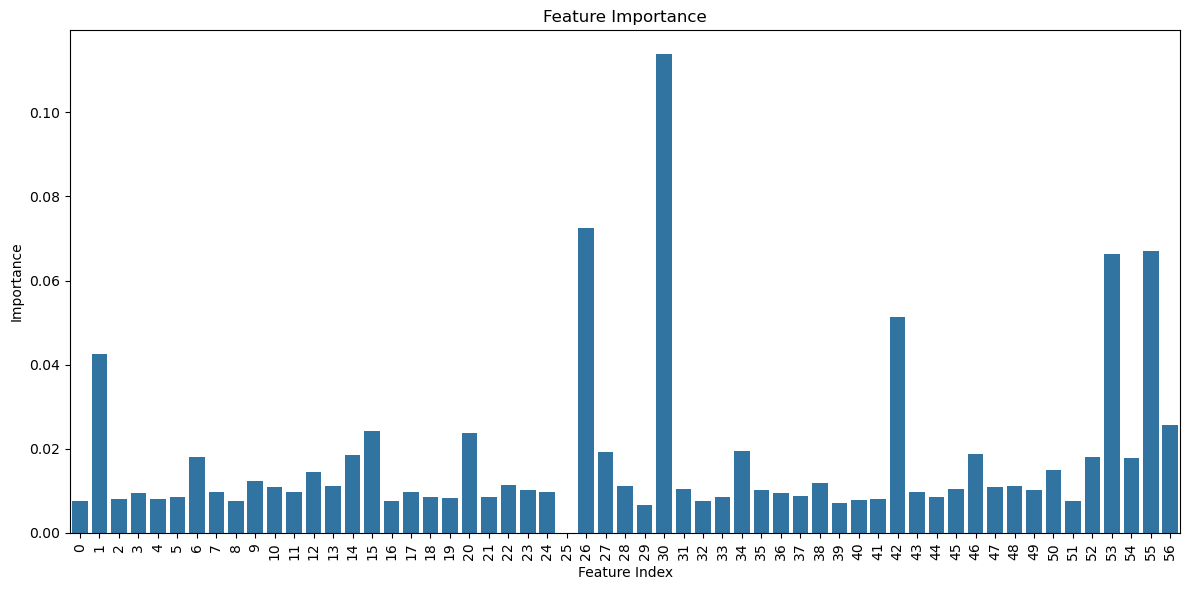

Top 20 most important features:
    feature_importance
30            0.113775
26            0.072488
55            0.067009
53            0.066189
42            0.051337
1             0.042655
56            0.025580
15            0.024253
20            0.023858
34            0.019526
27            0.019134
46            0.018785
14            0.018504
6             0.018017
52            0.017993
54            0.017736
50            0.014883
12            0.014398
9             0.012330
38            0.011807


In [10]:
# Show feature importance for the best ML model
if hasattr(best_ml_model, 'feature_importances_'):
    feature_importances = best_ml_model.feature_importances_
    importance_df = pd.DataFrame({'feature_importance': feature_importances})
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importance_df.index, y='feature_importance', data=importance_df)
    plt.title('Feature Importance')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Display top 20 most important features
    top_features = importance_df.sort_values('feature_importance', ascending=False).head(20)
    print("Top 20 most important features:")
    print(top_features)

## 6. Train Deep Learning Models

We'll train CNN, LSTM, and hybrid CNN-LSTM models specifically designed for EEG time series data.

In [11]:
# Reshape data for CNN/LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

num_classes = len(np.unique(y_train_encoded))
input_shape = (X_train_reshaped.shape[1], 1)

print(f"Reshaped data for deep learning - shape: {X_train_reshaped.shape}")

Reshaped data for deep learning - shape: (3999, 178, 1)


### 6.1 CNN Model

In [12]:
# CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

/home/lyes/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-10 18:10:44.538541: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 176, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 86, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,589 (3.00 MB)

 Trainable params: 787,589 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train CNN model
cnn_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True)
]

cnn_history = cnn_model.fit(
    X_train_reshaped, y_train_split,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,
    batch_size=32,
    callbacks=cnn_callbacks,
    verbose=1
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4069 - loss: 1.3793

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4072 - loss: 1.3787 - val_accuracy: 0.5010 - val_loss: 1.1540
Epoch 2/50
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4744 - loss: 1.2077

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4748 - loss: 1.2068 - val_accuracy: 0.5390 - val_loss: 1.0887
Epoch 3/50
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4881 - loss: 1.1595

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4884 - loss: 1.1587 - val_accuracy: 0.5760 - val_loss: 1.0229
Epoch 4/50
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5345 - loss: 1.0829

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5348 - loss: 1.0823 - val_accuracy: 0.6030 - val_loss: 0.9684
Epoch 5/50
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5609 - loss: 1.0371

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5612 - loss: 1.0364 - val_accuracy: 0.6090 - val_loss: 0.9481
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6044 - loss: 0.9663

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6044 - loss: 0.9661 - val_accuracy: 0.6150 - val_loss: 0.9471
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6111 - loss: 0.9422 - val_accuracy: 0.6090 - val_loss: 0.9562
Epoch 8/50
122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6337 - loss: 0.8955

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6342 - loss: 0.8942 - val_accuracy: 0.6250 - val_loss: 0.9373
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6656 - loss: 0.8398 - val_accuracy: 0.6170 - val_loss: 0.9829
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6624 - loss: 0.7996 - val_accuracy: 0.5880 - val_loss: 0.9973
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6972 - loss: 0.7261

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6974 - loss: 0.7258 - val_accuracy: 0.6290 - val_loss: 1.0343
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7330 - loss: 0.6646 - val_accuracy: 0.6270 - val_loss: 1.0921
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7478 - loss: 0.6187 - val_accuracy: 0.6020 - val_loss: 1.1065
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7573 - loss: 0.5985 - val_accuracy: 0.6240 - val_loss: 1.1403
Epoch 15/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7820 - loss: 0.5548 - val_accuracy: 0.6030 - val_loss: 1.1955
Epoch 16/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7939 - loss: 0.5286 - val_accuracy: 0.5900 - val_loss: 1.3262
Epoch 17/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8112 - loss: 0.4904 - val_accuracy: 0.6050 - val_loss: 1.6154
Epoch 18/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8231 - loss: 0.4433 - val_accuracy

### 6.2 LSTM Model

In [14]:
# LSTM model
lstm_model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=input_shape),
    Bidirectional(LSTM(100)),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()

/home/lyes/anaconda3/envs/DM_ENV/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 178, 200)       │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,005 (1.31 MB)

 Trainable params: 343,005 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train LSTM model
lstm_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True)
]

lstm_history = lstm_model.fit(
    X_train_reshaped, y_train_split,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,
    batch_size=32,
    callbacks=lstm_callbacks,
    verbose=1
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3826 - loss: 1.4409

125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - accuracy: 0.3830 - loss: 1.4403 - val_accuracy: 0.4880 - val_loss: 1.2130
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.4519 - loss: 1.2613 - val_accuracy: 0.4700 - val_loss: 1.1898
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.4636 - loss: 1.2509 - val_accuracy: 0.4740 - val_loss: 1.1657
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.4552 - loss: 1.2658 - val_accuracy: 0.4860 - val_loss: 1.2054
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4723 - loss: 1.2256

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.4723 - loss: 1.2256 - val_accuracy: 0.5200 - val_loss: 1.1226
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.4846 - loss: 1.2316 - val_accuracy: 0.4900 - val_loss: 1.2527
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.4849 - loss: 1.2706 - val_accuracy: 0.4970 - val_loss: 1.1790
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.4857 - loss: 1.2118 - val_accuracy: 0.5090 - val_loss: 1.1243
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.4889 - loss: 1.1823 - val_accuracy: 0.4960 - val_loss: 1.1836
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.4811 - loss: 1.1972 - val_accuracy: 0.4900 - val_loss: 1.1975
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5108 - loss: 1.1834

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5108 - loss: 1.1832 - val_accuracy: 0.5390 - val_loss: 1.1215
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5236 - loss: 1.1358 - val_accuracy: 0.5230 - val_loss: 1.1086
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5198 - loss: 1.1273

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5199 - loss: 1.1272 - val_accuracy: 0.5550 - val_loss: 1.0707
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5347 - loss: 1.0990 - val_accuracy: 0.5380 - val_loss: 1.0909
Epoch 15/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5324 - loss: 1.1122 - val_accuracy: 0.5530 - val_loss: 1.0620
Epoch 16/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5394 - loss: 1.0994 - val_accuracy: 0.5500 - val_loss: 1.0636
Epoch 17/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5362 - loss: 1.0856 - val_accuracy: 0.5500 - val_loss: 1.0408
Epoch 18/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5320 - loss: 1.0878 - val_accuracy: 0.5450 - val_loss: 1.0582
Epoch 19/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5234 - loss: 1.1186 - val_accuracy: 0.5320 - val_loss: 1.0964
Epoch 20/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.4993 - loss: 1.140

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5284 - loss: 1.0948 - val_accuracy: 0.5610 - val_loss: 1.0250
Epoch 22/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5361 - loss: 1.0743 - val_accuracy: 0.5580 - val_loss: 1.0386
Epoch 23/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5518 - loss: 1.0611 - val_accuracy: 0.5390 - val_loss: 1.0501
Epoch 24/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5331 - loss: 1.0577

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5332 - loss: 1.0576 - val_accuracy: 0.5650 - val_loss: 1.0249
Epoch 25/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5517 - loss: 1.0470

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5517 - loss: 1.0469 - val_accuracy: 0.5730 - val_loss: 1.0185
Epoch 26/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5619 - loss: 1.0454 - val_accuracy: 0.5570 - val_loss: 1.0341
Epoch 27/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5560 - loss: 1.0288

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5560 - loss: 1.0287 - val_accuracy: 0.5820 - val_loss: 1.0130
Epoch 28/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5551 - loss: 1.0131 - val_accuracy: 0.5750 - val_loss: 1.0124
Epoch 29/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5507 - loss: 1.0236 - val_accuracy: 0.5740 - val_loss: 1.0209
Epoch 30/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5561 - loss: 1.0054

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5561 - loss: 1.0053 - val_accuracy: 0.5860 - val_loss: 0.9998
Epoch 31/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5675 - loss: 0.9985 - val_accuracy: 0.5800 - val_loss: 1.0099
Epoch 32/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5695 - loss: 0.9986 - val_accuracy: 0.5840 - val_loss: 1.0046
Epoch 33/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5764 - loss: 0.9836 - val_accuracy: 0.5670 - val_loss: 1.0318
Epoch 34/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5794 - loss: 0.9936 - val_accuracy: 0.5710 - val_loss: 1.0186
Epoch 35/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5823 - loss: 0.9921 - val_accuracy: 0.5760 - val_loss: 0.9887
Epoch 36/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5855 - loss: 0.9675

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.5856 - loss: 0.9675 - val_accuracy: 0.6050 - val_loss: 0.9827
Epoch 37/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.6005 - loss: 0.9569 - val_accuracy: 0.5810 - val_loss: 1.0177
Epoch 38/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5944 - loss: 0.9598

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5944 - loss: 0.9597 - val_accuracy: 0.6100 - val_loss: 0.9990
Epoch 39/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.6090 - loss: 0.9342 - val_accuracy: 0.6020 - val_loss: 1.0110
Epoch 40/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.6087 - loss: 0.9257 - val_accuracy: 0.5580 - val_loss: 1.0655
Epoch 41/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.5859 - loss: 0.9577 - val_accuracy: 0.5940 - val_loss: 1.0172
Epoch 42/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.6137 - loss: 0.9144 - val_accuracy: 0.5990 - val_loss: 1.0181
Epoch 43/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.6064 - loss: 0.9218 - val_accuracy: 0.5590 - val_loss: 1.0261
Epoch 44/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.6096 - loss: 0.9212 - val_accuracy: 0.5850 - val_loss: 1.0111
Epoch 45/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.6246 - loss: 0.877

### 6.3 CNN-LSTM Hybrid Model

In [16]:
# CNN-LSTM model
input_layer = Input(shape=input_shape)

# CNN branch
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)

# LSTM branch
lstm1 = Bidirectional(LSTM(100, return_sequences=True))(input_layer)
lstm2 = Bidirectional(LSTM(100))(lstm1)

# Merge branches
flatten_cnn = Flatten()(pool2)
merged = tf.keras.layers.concatenate([flatten_cnn, lstm2])

# Output layers
dense1 = Dense(100, activation='relu')(merged)
dropout = Dropout(0.5)(dense1)
output = Dense(num_classes, activation='softmax')(dropout)

cnn_lstm_model = Model(inputs=input_layer, outputs=output)

cnn_lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_lstm_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 176, 64)   │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 88, 64)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 86, 128)   │     24,704 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 43, 128)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 178, 200)  │     81,600 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5504)      │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 200)       │    240,800 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5704)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 100)       │    570,500 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │        505 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 918,365 (3.50 MB)

 Trainable params: 918,365 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train CNN-LSTM model
cnn_lstm_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_cnn_lstm_model.h5', monitor='val_accuracy', save_best_only=True)
]

cnn_lstm_history = cnn_lstm_model.fit(
    X_train_reshaped, y_train_split,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,
    batch_size=32,
    callbacks=cnn_lstm_callbacks,
    verbose=1
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.4130 - loss: 1.3694

125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 201ms/step - accuracy: 0.4134 - loss: 1.3688 - val_accuracy: 0.5200 - val_loss: 1.1246
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5032 - loss: 1.1869

125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.5033 - loss: 1.1867 - val_accuracy: 0.5790 - val_loss: 1.0708
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 248ms/step - accuracy: 0.5321 - loss: 1.1109 - val_accuracy: 0.5710 - val_loss: 1.0517
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5596 - loss: 1.0681

125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 239ms/step - accuracy: 0.5596 - loss: 1.0679 - val_accuracy: 0.5900 - val_loss: 1.0243
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.5762 - loss: 1.0371 - val_accuracy: 0.5840 - val_loss: 1.0203
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 232ms/step - accuracy: 0.5938 - loss: 0.9880 - val_accuracy: 0.5890 - val_loss: 1.0252
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6163 - loss: 0.9482

125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 232ms/step - accuracy: 0.6163 - loss: 0.9481 - val_accuracy: 0.5990 - val_loss: 1.0158
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6211 - loss: 0.8997

125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.6212 - loss: 0.8996 - val_accuracy: 0.6070 - val_loss: 1.0278
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.6337 - loss: 0.8651 - val_accuracy: 0.5880 - val_loss: 1.0362
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.6634 - loss: 0.8478 - val_accuracy: 0.5960 - val_loss: 1.0484
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 242ms/step - accuracy: 0.6815 - loss: 0.7895 - val_accuracy: 0.5940 - val_loss: 1.0769
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.7029 - loss: 0.7314 - val_accuracy: 0.6010 - val_loss: 1.0912
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.7091 - loss: 0.7191 - val_accuracy: 0.5910 - val_loss: 1.1106
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 230ms/step - accuracy: 0.7315 - loss: 0.6475 - val_accuracy: 0.5890 - val_loss: 1.1626
Epoch 15/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 228ms/step - accuracy: 0.7436 - loss: 0.6145

### Compare deep learning models

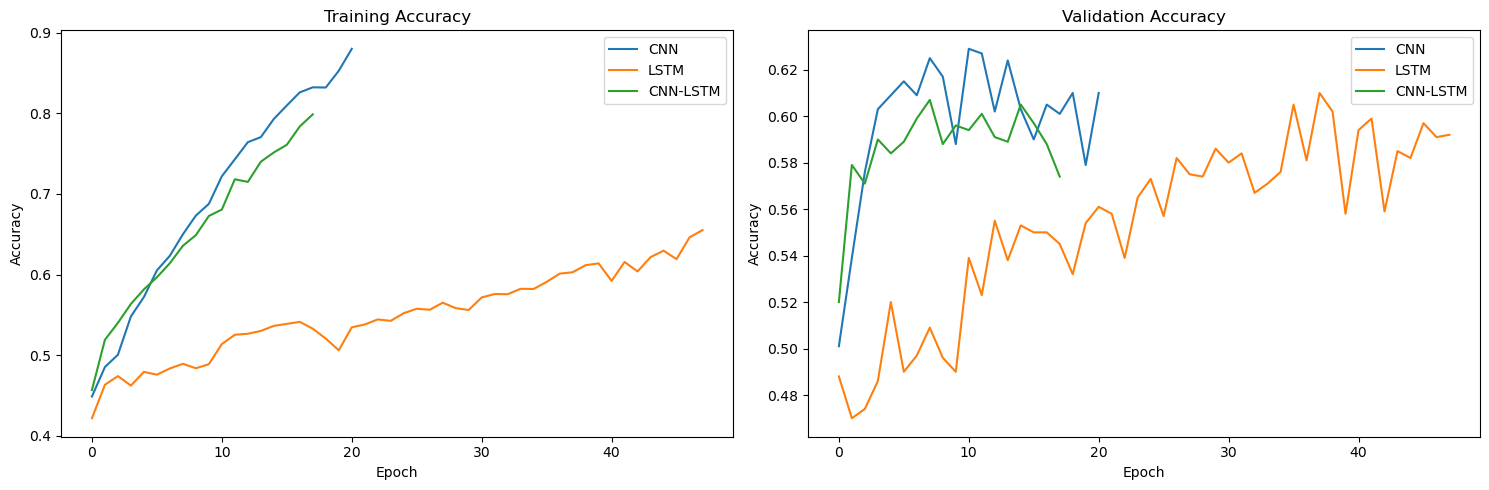

CNN Validation Accuracy: 0.6290
LSTM Validation Accuracy: 0.6100
CNN-LSTM Validation Accuracy: 0.6070

Best deep learning model: CNN with accuracy: 0.6290


In [18]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN')
plt.plot(lstm_history.history['accuracy'], label='LSTM')
plt.plot(cnn_lstm_history.history['accuracy'], label='CNN-LSTM')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['val_accuracy'], label='CNN')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM')
plt.plot(cnn_lstm_history.history['val_accuracy'], label='CNN-LSTM')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate models on validation set
cnn_val_loss, cnn_val_acc = cnn_model.evaluate(X_val_reshaped, y_val, verbose=0)
lstm_val_loss, lstm_val_acc = lstm_model.evaluate(X_val_reshaped, y_val, verbose=0)
cnn_lstm_val_loss, cnn_lstm_val_acc = cnn_lstm_model.evaluate(X_val_reshaped, y_val, verbose=0)

print(f"CNN Validation Accuracy: {cnn_val_acc:.4f}")
print(f"LSTM Validation Accuracy: {lstm_val_acc:.4f}")
print(f"CNN-LSTM Validation Accuracy: {cnn_lstm_val_acc:.4f}")

# Find best deep learning model
dl_models = {'CNN': cnn_model, 'LSTM': lstm_model, 'CNN-LSTM': cnn_lstm_model}
dl_accs = {'CNN': cnn_val_acc, 'LSTM': lstm_val_acc, 'CNN-LSTM': cnn_lstm_val_acc}
best_dl_model_name = max(dl_accs, key=dl_accs.get)
best_dl_model = dl_models[best_dl_model_name]

print(f"\nBest deep learning model: {best_dl_model_name} with accuracy: {dl_accs[best_dl_model_name]:.4f}")

### Evaluate best deep learning model

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best DL Model Validation Accuracy: 0.6290

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.58      0.61       102
           1       0.41      0.44      0.43       140
           2       0.65      0.67      0.66       400
           3       0.72      0.88      0.79       208
           4       0.63      0.39      0.48       150

    accuracy                           0.63      1000
   macro avg       0.61      0.59      0.59      1000
weighted avg       0.63      0.63      0.62      1000



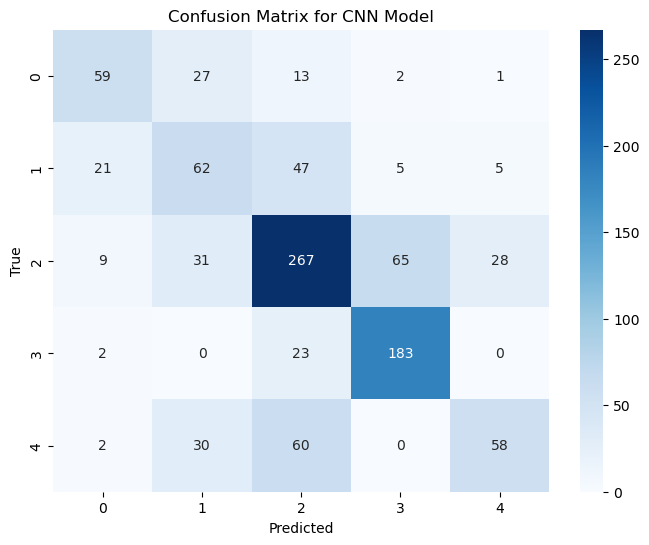

In [19]:
# Evaluate best DL model
dl_val_preds = np.argmax(best_dl_model.predict(X_val_reshaped), axis=1)

print(f"Best DL Model Validation Accuracy: {accuracy_score(y_val, dl_val_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, dl_val_preds))

# Plot confusion matrix
cm = confusion_matrix(y_val, dl_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_dl_model_name} Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 7. Create Ensemble Model

We'll combine the best traditional ML model and best deep learning model to create a powerful ensemble model.

In [20]:
def create_ensemble(ml_model, dl_model, X_train_feat, y_train, X_train_raw):
    print("Creating ensemble model...")
    
    # Reshape raw data for deep learning model
    X_train_reshaped = X_train_raw.reshape(X_train_raw.shape[0], X_train_raw.shape[1], 1)
    
    # Get predictions from both models
    ml_pred_proba = ml_model.predict_proba(X_train_feat)
    dl_pred_proba = dl_model.predict(X_train_reshaped)
    
    # Combine predictions (meta-features)
    meta_features = np.column_stack((ml_pred_proba, dl_pred_proba))
    
    # Train a meta-classifier
    meta_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
    meta_classifier.fit(meta_features, y_train)
    
    return meta_classifier

# Create ensemble
ensemble_model = create_ensemble(best_ml_model, best_dl_model, 
                                X_train_feat_scaled, y_train_split, 
                                X_train_scaled)

Creating ensemble model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


### Evaluate ensemble model on validation set

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Ensemble Model Validation Accuracy: 0.6990

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.71      0.65       102
           1       0.66      0.54      0.60       140
           2       0.69      0.73      0.71       400
           3       0.80      0.80      0.80       208
           4       0.69      0.61      0.65       150

    accuracy                           0.70      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.70      0.70      0.70      1000



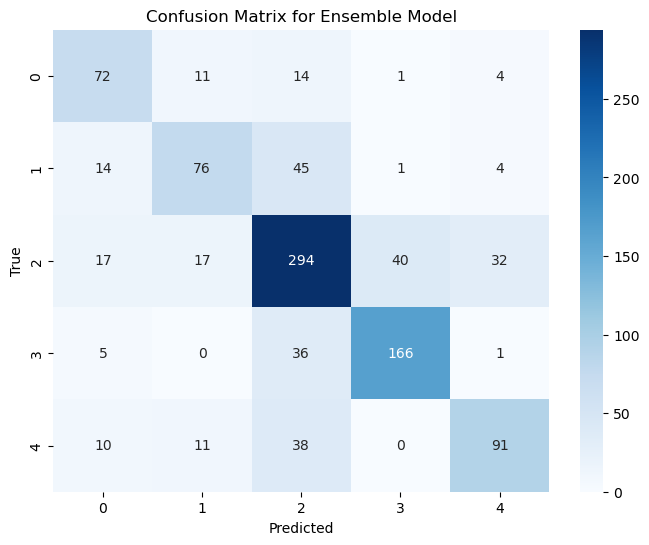

In [21]:
# Get validation predictions from both models
ml_val_pred_proba = best_ml_model.predict_proba(X_val_feat_scaled)
dl_val_pred_proba = best_dl_model.predict(X_val_reshaped)

# Combine predictions for ensemble
meta_features_val = np.column_stack((ml_val_pred_proba, dl_val_pred_proba))
ensemble_val_preds = ensemble_model.predict(meta_features_val)

# Calculate accuracy
ensemble_val_acc = accuracy_score(y_val, ensemble_val_preds)
print(f"Ensemble Model Validation Accuracy: {ensemble_val_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, ensemble_val_preds))

# Plot confusion matrix
cm = confusion_matrix(y_val, ensemble_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 8. Compare All Models

Let's compare the performance of all models on the validation set.

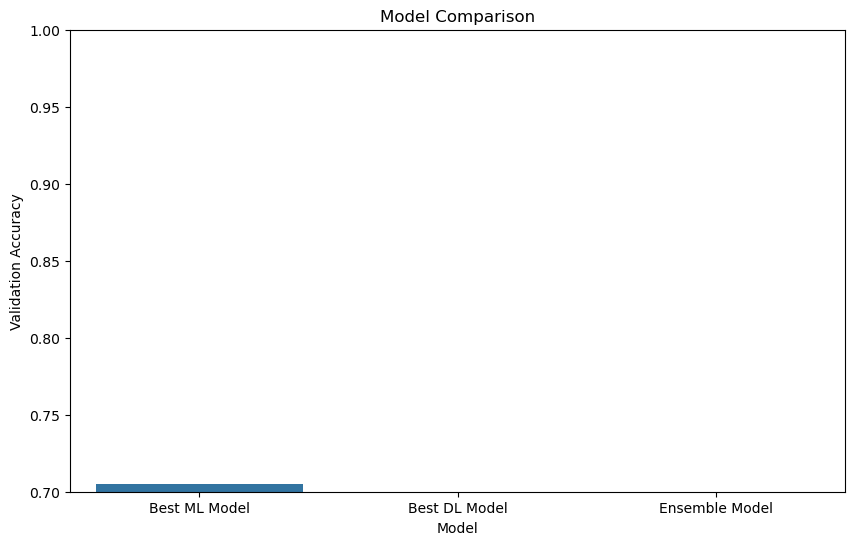

Best model overall: Best ML Model with accuracy: 0.7050


In [22]:
# Compare all models
model_accuracies = {
    'Best ML Model': accuracy_score(y_val, ml_val_preds),
    'Best DL Model': accuracy_score(y_val, dl_val_preds),
    'Ensemble Model': ensemble_val_acc
}

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()))
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.ylim(0.7, 1.0) # Adjust as needed
plt.show()

# Find the best model overall
best_model_name = max(model_accuracies, key=model_accuracies.get)
print(f"Best model overall: {best_model_name} with accuracy: {model_accuracies[best_model_name]:.4f}")

## 9. Make Predictions on Test Data

Now we'll use our best model to make predictions on the test data.

In [23]:
print("Making predictions on test data...")

# Get predictions from both models for test data
ml_pred_proba_test = best_ml_model.predict_proba(X_test_feat_scaled)
dl_pred_proba_test = best_dl_model.predict(X_test_reshaped)

# Combine predictions for ensemble
meta_features_test = np.column_stack((ml_pred_proba_test, dl_pred_proba_test))
ensemble_predictions = ensemble_model.predict(meta_features_test)

# Convert predictions back to original labels
final_predictions = le.inverse_transform(ensemble_predictions)

# Save predictions
pd.DataFrame(final_predictions).to_csv('predictions.csv', index=False, header=False)
print("Predictions saved to 'predictions.csv'")

# Display first few predictions
print("\nFirst 10 predictions:")
print(final_predictions[:10])

Making predictions on test data...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predictions saved to 'predictions.csv'

First 10 predictions:
[0 0 2 0 0 1 0 0 0 0]


## 11. Visualization for Report

Generate visualizations for your report.

/tmp/ipykernel_720864/2840200324.py:15: UserWarning: nperseg = 256 is greater than input length  = 178, using nperseg = 178
  f, t, Sxx = signal.spectrogram(eeg_signal_data, fs)


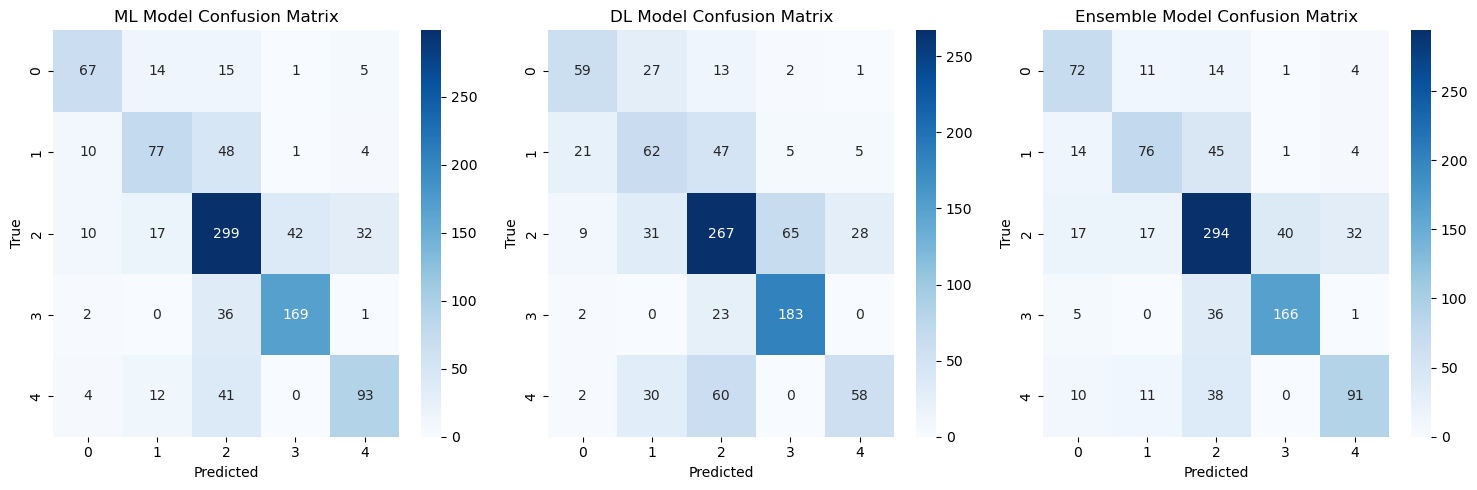

In [24]:
# 1. Plot example signals with spectrograms
def plot_signal_with_spectrogram(eeg_signal_data, title):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(eeg_signal_data)
    plt.title(f'{title} - Time Domain')
    plt.ylabel('Amplitude')
    plt.xlabel('Time Points')
    
    plt.subplot(2, 1, 2)
    fs = 100  # Assuming 100 Hz
    # Use the imported 'signal' module (scipy.signal)
    # and pass the function argument 'eeg_signal_data' to it.
    f, t, Sxx = signal.spectrogram(eeg_signal_data, fs)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'{title} - Spectrogram')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    
    plt.tight_layout()
    return plt

# Plot for each class
for c in np.unique(y_train):
    class_idx = np.where(y_train == c)[0][0]
    fig = plot_signal_with_spectrogram(X_train[class_idx], f'Class {c}')
    fig.savefig(f'class_{c}_signal.png')
    plt.close()

# 2. Confusion matrices comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_val, ml_val_preds), annot=True, fmt='d', cmap='Blues')
plt.title('ML Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_val, dl_val_preds), annot=True, fmt='d', cmap='Blues')
plt.title('DL Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_val, ensemble_val_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Ensemble Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png')
plt.show()